This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

I've got an annoying warning message from the wrapper and I can't figure out how to get rid of it. If anybody figures this out please send a message to stevecoggeshall@gmail.com

In [3]:

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

     ---------------------------------------- 1.0/1.0 MB 3.1 MB/s eta 0:00:00


In [4]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 200
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [ ]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
#     df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

In [6]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

NameError: name 'filter_score' is not defined

In [ ]:
filter_score.head(30)

In [ ]:
filter_score.tail(10)

In [ ]:
filter_score.shape

In [ ]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

In [ ]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

In [ ]:
df_keep.shape

In [ ]:
Y.head()

In [ ]:
Y = Y.values
Y_save = Y.copy()

In [ ]:
# Y = np.array(Y)
X = df_keep
print(Y)

In [ ]:
print('time to here:', dt.datetime.now() - start_time)

In [ ]:
print(X.shape,Y.shape)

In [ ]:
print(type(X),type(Y))

In [ ]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [ ]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [ ]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=40,num_leaves=4) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:10:29.394128


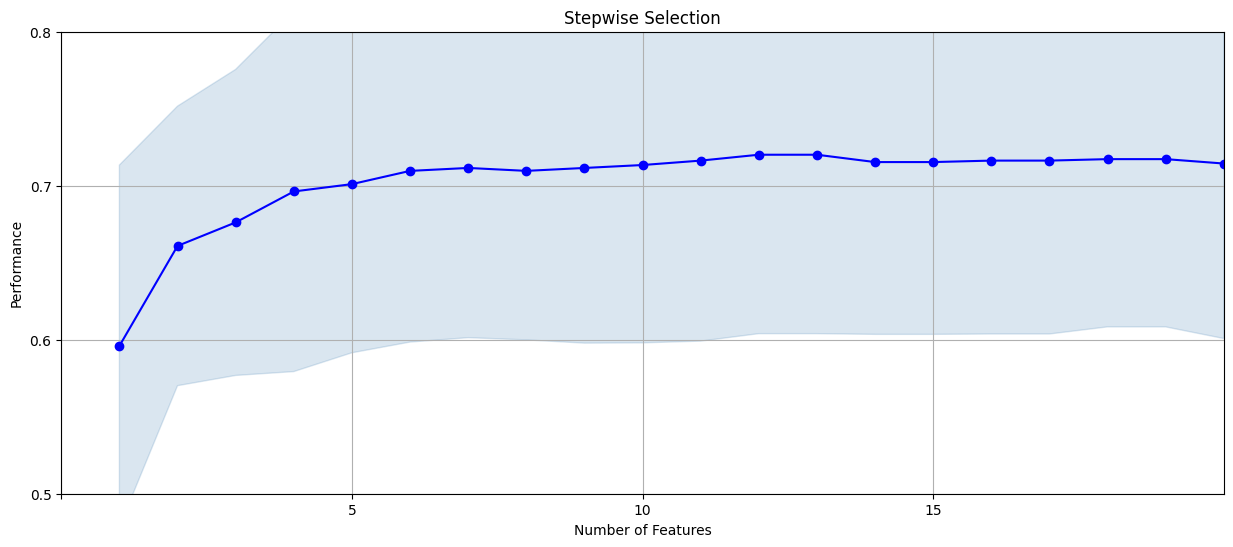

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.5, .8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [24]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(15,)","[0.6908396946564885, 0.5670498084291188, 0.709...",0.595961,"(card_merch_total_14,)",0.188308,0.117474,0.067823,1.0,card_merch_total_14
2,"(15, 16)","[0.7404580152671756, 0.6360153256704981, 0.744...",0.660912,"(card_merch_total_14, card_zip3_max_14)",0.145474,0.090752,0.052396,2.0,card_zip3_max_14
3,"(15, 16, 173)","[0.7595419847328244, 0.632183908045977, 0.7786...",0.676176,"(card_merch_total_14, card_zip3_max_14, card_m...",0.159284,0.099367,0.05737,3.0,card_merch_avg_14
4,"(15, 16, 153, 173)","[0.7900763358778626, 0.6896551724137931, 0.797...",0.696269,"(card_merch_total_14, card_zip3_max_14, state_...",0.187482,0.116958,0.067526,4.0,state_des_max_1
5,"(15, 16, 45, 153, 173)","[0.767175572519084, 0.685823754789272, 0.82061...",0.701036,"(card_merch_total_14, card_zip3_max_14, card_z...",0.175552,0.109516,0.063229,5.0,card_zip_max_60
6,"(15, 16, 45, 153, 169, 173)","[0.7977099236641222, 0.6934865900383141, 0.812...",0.709631,"(card_merch_total_14, card_zip3_max_14, card_z...",0.17818,0.111155,0.064176,6.0,Card_Merchnum_desc_avg_30
7,"(15, 16, 45, 64, 153, 169, 173)","[0.7862595419847328, 0.6973180076628352, 0.824...",0.711543,"(card_merch_total_14, card_zip3_max_14, card_z...",0.176668,0.110212,0.063631,7.0,Card_Merchnum_Zip_total_60
8,"(15, 16, 45, 48, 64, 153, 169, 173)","[0.7748091603053435, 0.7049808429118773, 0.824...",0.709642,"(card_merch_total_14, card_zip3_max_14, card_z...",0.17591,0.10974,0.063358,8.0,Card_Merchdesc_Zip_total_30
9,"(15, 16, 45, 48, 64, 153, 169, 173, 192)","[0.8053435114503816, 0.6896551724137931, 0.816...",0.711536,"(card_merch_total_14, card_zip3_max_14, card_z...",0.182332,0.113746,0.065671,9.0,card_zip_avg_1
10,"(15, 16, 45, 48, 64, 153, 169, 173, 174, 192)","[0.8053435114503816, 0.6819923371647509, 0.828...",0.713437,"(card_merch_total_14, card_zip3_max_14, card_z...",0.1851,0.115472,0.066668,10.0,Card_Merchnum_Zip_avg_14


In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1             card_merch_total_14
2                card_zip3_max_14
3               card_merch_avg_14
4                 state_des_max_1
5                 card_zip_max_60
6       Card_Merchnum_desc_avg_30
7      Card_Merchnum_Zip_total_60
8     Card_Merchdesc_Zip_total_30
9                  card_zip_avg_1
10       Card_Merchnum_Zip_avg_14
11               card_merch_avg_3
12            card_merch_total_60
13        Card_Merchnum_Zip_avg_3
14       Card_Merchdesc_Zip_avg_7
15           Card_Merchdesc_avg_7
16        Card_Merchnum_Zip_avg_1
17       Card_Merchnum_desc_avg_7
18       Card_Merchnum_desc_max_1
19               card_merch_avg_1
20              merch_state_max_1
Name: variable name, dtype: object

In [27]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_state_total_7,0.654135
...,...
merch_zip_unique_count_for_merch_state_7,0.000022
Card_Merchdesc_Zip_unique_count_for_card_state_1,0.000022
card_zip3_unique_count_for_card_state_1,0.000017


In [28]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_merch_total_14
card_zip3_max_14
card_merch_avg_14
state_des_max_1
card_zip_max_60


In [29]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [30]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_merch_total_14,0.630048
1,2,card_zip3_max_14,0.629515
2,3,card_merch_avg_14,0.518386
3,4,state_des_max_1,0.524301
4,5,card_zip_max_60,0.605193
5,6,Card_Merchnum_desc_avg_30,0.519394
6,7,Card_Merchnum_Zip_total_60,0.597034
7,8,Card_Merchdesc_Zip_total_30,0.604455
8,9,card_zip_avg_1,0.514891
9,10,Card_Merchnum_Zip_avg_14,0.518122


In [31]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_merch_total_14',
 'card_zip3_max_14',
 'card_merch_avg_14',
 'state_des_max_1',
 'card_zip_max_60',
 'Card_Merchnum_desc_avg_30',
 'Card_Merchnum_Zip_total_60',
 'Card_Merchdesc_Zip_total_30',
 'card_zip_avg_1',
 'Card_Merchnum_Zip_avg_14',
 'card_merch_avg_3',
 'card_merch_total_60',
 'Card_Merchnum_Zip_avg_3',
 'Card_Merchdesc_Zip_avg_7',
 'Card_Merchdesc_avg_7',
 'Card_Merchnum_Zip_avg_1',
 'Card_Merchnum_desc_avg_7',
 'Card_Merchnum_desc_max_1',
 'card_merch_avg_1',
 'merch_state_max_1',
 'Recnum',
 'Fraud']

In [32]:
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_state_total_7,0.654135
...,...
merch_zip_unique_count_for_merch_state_7,0.000022
Card_Merchdesc_Zip_unique_count_for_card_state_1,0.000022
card_zip3_unique_count_for_card_state_1,0.000017


In [33]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 12.5 s, sys: 1.78 s, total: 14.3 s
Wall time: 14.5 s


(96397, 2344)

In [34]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [35]:
df_keep.to_csv('vars_final.csv',index=False)

In [36]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:10:44.857541


In [37]:
%pwd

'/Users/stevecoggeshall/Documents/Teaching/Data sets/done/transactions/transactions 2023 new'